# PDFファイルからデータを取得
## pypdfをインストール

In [1]:
!pip install pypdf

  Using cached pypdf-4.2.0-py3-none-any.whl.metadata (7.4 kB)
Using cached pypdf-4.2.0-py3-none-any.whl (290 kB)


In [22]:
import os
import re
import json
import csv
from langchain.document_loaders import PyPDFLoader
from langchain.schema import HumanMessage

In [14]:
def extract_and_parse_json(text):
    """
    テキストからJSON文字列を抽出し、辞書型に変換する関数
    """
    try:
        # 「text」からJSON文字列を抽出する
        match = re.search(r"\{.*\}", text, re.DOTALL)
        json_string = match.group() if match else ""
        # JSON文字列をPythonの辞書型に変換
        return json.loads(json_string)
    except (AttributeError, json.JSONDecodeError):
        # どちらかの操作が失敗した場合は、空の辞書型を返す
        return {}

In [15]:
def load_all_pdfs(directory):
    """
    「directory」フォルダ以下のPDFファイルを読み込み、JSON形式のデータの配列を返す関数
    """
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.0)

    # 「directory」フォルダ以下のPDFファイルの一覧を取得
    pdf_files = [f for f in os.listdir(directory) if f.endswith(".pdf")]

    # 各PDFのJSONを格納する配列を定義
    contents = []

    for pdf_file in pdf_files:
        loader = PyPDFLoader(os.path.join(directory, pdf_file))
        pages = loader.load_and_split()
        prompt = f"""
        以下に示すデータは、請求書のPDFデータをテキスト化したものです。
        請求書データを、下記のキーを持つJSON形式に変換してください。
        キーに該当するテキストが見つからなければ、値は空欄にしてください。

        また、下記は弊社の情報なので、JSONの出力に含めないでください。
        ・AIビジネスソリューション株式会社
        ・〒135-0021 東京都江東区有明1-1-1

        ###

        キー：
        ・日付
        ・請求番号
        ・インボイス番号
        ・会社名
        ・住所
        ・件名
        ・請求金額
        ・お支払い期限
        ・詳細
        ・小計
        ・消費税
        ・請求金額（合計）
        ・振込先

        ###

        以下はとある請求書のデータをJSON形式に変換した場合の例です。

        ###

        例：
        [(
            "日付": "2023年10月31日",
            "請求番号": "2023-1031",
            "インボイス番号": "T0123456789012",
            "会社名": "テクノロジーソリューションズ株式会社",
            "住所": "〒123-4567 東京都中央区銀座1-1-1",
            "件名": "ウェブサイトリニューアルプロジェクト",
            "請求金額": "667,810",
            "お支払い期限": "2023年11月30日",
            "詳細": "ディレクション費用 ¥100,000 / 開発費用 ¥150,000",
            "小計": "250,000",
            "消費税": "25,000",
            "請求金額（合計）": "667,810",
            "振込先": "AA銀行 BB支店 普通 1234567"
        )]

        ###

        データ：
        {pages[0].page_content}
        """

        result = llm([HumanMessage(content=prompt)])

        contents.append(extract_and_parse_json(result.content))
    return contents

In [16]:
def write_to_csv(billing_data):
    # CSVファイル名
    csv_file = "invoices.csv"

    # ヘッダーを決定（JSONのキーから）
    header = billing_data[0].keys()

    # CSVファイルを書き込みモードで開き、データを書き込む
    with open(csv_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=header)
        writer.writeheader()
        writer.writerows(billing_data)

In [18]:
def main_write_csv():
    # 「data」フォルダ以下のPDFファイルを読み込み、json形式のデータを受け取る
    billing_data = load_all_pdfs("data")
    print("読み込みが完了しました")

    # json形式のデータをCSVファイルに書き込む
    write_to_csv(billing_data)
    print("CSVファイルへの書き込みが完了しました")

In [23]:
main_write_csv()

読み込みが完了しました
CSVファイルへの書き込みが完了しました


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator, FuncFormatter

In [25]:
def draw_graph(filename):
    # invoices.csvファイルからpandasのDataFrameに読み込み（数値のカンマ区切りに対応）
    df = pd.read_csv("invoices.csv", thousands=",")

    # 日付のフォーマットを変換
    df["日付"] = pd.to_datetime(
        df["日付"].str.replace("年", "-").str.replace("月", "-").str.replace("日", ""),
        format="%Y-%m-%d",
    )

    # グラフを描画
    fig, ax = plt.subplots()
    ax.bar(df["日付"], df["請求金額（合計）"])
    ax.set_xlabel("date")
    ax.set_ylabel("price")
    ax.set_xticks(df["日付"])
    ax.set_xticklabels(df["日付"].dt.strftime("%Y-%m-%d"), rotation=45)

    # y軸の最小値を0に設定
    ax.set_ylim(0, max(df["請求金額（合計）"]) + 100000)

    # 縦軸のラベルを元の数字のまま表示
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))

    plt.tight_layout()
    plt.show()

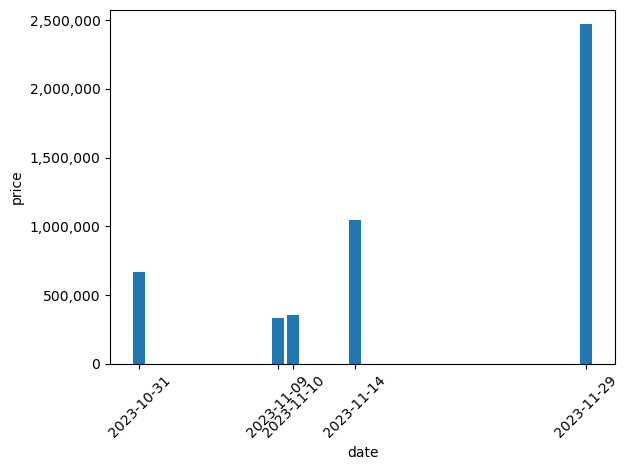

In [27]:
draw_graph("invoices.csv")

In [26]:
def main_draw_graph():
    # 「data」フォルダ以下のPDFファイルを読み込み、json形式のデータを受け取る
    billing_data = load_all_pdfs("data")
    print("読み込みが完了しました")

    # json形式のデータをCSVファイルに書き込む
    write_to_csv(billing_data)
    print("CSVファイルへの書き込みが完了しました")

    draw_graph("invoices.csv")

# PDFの内容を元に回答するチャットボット

In [4]:
#ベクトルDBのchromadbをインストール
!pip install chromadb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.1.6 requires openai<2.0.0,>=1.24.0, but you have openai 0.28.0 which is incompatible.
spyder 5.4.3 requires ipython!=8.10.0,!=8.8.0,!=8.9.0,<9.0.0,>=7.31.1, but you have ipython 8.8.0 which is incompatible.



     ---------------------------------------- 0.0/67.3 kB ? eta -:--:--
     ---------------------------------------- 67.3/67.3 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/526.8 kB ? eta -:--:--
   --------------------------------------- 526.8/526.8 kB 32.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/151.6 kB ? eta -:--:--
   ---------------------------------------- 151.6/151.6 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/158.1 kB ? eta -:--:--
   ---------------------------------------- 158.1/158.1 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/92.0 kB ? eta -:

In [7]:
!pip install pymupdf

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB 682.7 kB/s eta 0:00:05
   - -------------------------------------- 0.1/3.2 MB 919.0 kB/s eta 0:00:04
   ----------------- ---------------------- 1.4/3.2 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 3.2/3.2 MB 18.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/24.9 MB ? eta -:--:--
   ----- ---------------------------------- 3.6/24.9 MB 77.1 MB/s eta 0:00:01
   -------------- ------------------------- 9.1/24.9 MB 116.6 MB/s eta 0:00:01
   ----------------------- ---------------- 14.7/24.9 MB 131.2 MB/s eta 0:00:01
   ------------------------------- -------- 19.6/24.9 MB 131.2 MB/s eta 0:00:01
   ---------------------------------------  24.9/24.9 MB 108.8 MB/s eta 0:00:01
   ---------------------------------------  24.9/24.9 MB 108.8 MB/s eta 0:00:01
   ---------------------------------------- 24.9/24.9 MB 65.1 MB/s eta 0:0

In [8]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.indexes import VectorstoreIndexCreator

In [9]:
#PDFファイルを読み込む
loader = PyMuPDFLoader("Version2020_02_13_01.pdf")
#インデックスを作成
index = VectorstoreIndexCreator().from_loaders([loader])
#入力指示
print("質問を入力してください")
#入力からインデックス
answer = index.query(input())
#回答を得る
print(answer)

質問を入力してください


 Tkinterについて教えてください


 TkinterはPythonのGUIフレームワークの一つで、Tcl/TkをPythonから利用できるようにしたものです。GUIアプリケーションの作成に使用され、ボタンやテキストエディタなどの部品を簡単に作成することができます。また、イベント駆動型プログラミングを行うことができ、ユーザの操作に応答するプログラムを記述することができます。


In [10]:
print("質問を入力してください")
#入力からインデックス
answer = index.query(input())
#回答を得る
print(answer)

質問を入力してください


 フラクタル図形を描くには


 関数の中で自分自身を呼び出す（再帰）を使う


In [12]:
#PDFファイルを読み込む
loader01 = PyMuPDFLoader("Version2020_02_13_01.pdf")
loader02 = PyMuPDFLoader("Version2020_02_13_02.pdf")
#インデックスを和作成
index = VectorstoreIndexCreator().from_loaders([loader01, loader02])
#入力指示
print("質問を入力してください")
#入力からインデックス
answer = index.query(input())
#回答を得る
print(answer)

質問を入力してください


 フラクタル図形を描くには


 関数の中で自分自身を呼び出す（再帰）を使う。


In [13]:
print("質問を入力してください")
#入力からインデックス
answer = index.query(input())
#回答を得る
print(answer)

質問を入力してください


 Tkinterとは何ですか？


 TkinterはPythonから利用できるGUI用のフレームワークです。
